In [14]:
def convert_path(path):
    """
    Convert a file path with backslashes to forward slashes.
    """
    return path.replace('\\', '/')

# Example usage
original_path = input("Enter the folder path with backslashes: ")

directory = convert_path(original_path)

print("Converted Path:", directory)

# G:/PIV_compare/Bubble_Seep

Converted Path: G:/PIV_compare/Bubble_in_chain


In [15]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from matplotlib.lines import Line2D

# Set the font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

KINEMATIC_VISCOSITY = 1.0e-5  


In [23]:
"""
 u = velocity in z direction U_z
 v = velocity in x direction U_r
"""

# Global variable for the main path
# MAIN_PATH = 'G:/PIV_compare/Bubble_Seep/01082024_Pylon_RaspPi_Cam'


def read_filenames(folder_name, MAIN_PATH):
    """
    Reads all filenames in the specified folder.
a
    :param folder_name: Name of the folder within the main path.
    :return: List of file names.
    """
    folder_path = os.path.join(MAIN_PATH, folder_name)
    filenames = []

    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return filenames

    for file in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file)):
            filenames.append(file)

    return filenames

def check_folder(folder_name, MAIN_PATH):
    """
    Creates a 'figures' folder in the main directory if it doesn't exist.
    """
    folder_path = os.path.join(MAIN_PATH, folder_name)

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Created folder: '{folder_name}' at {folder_path}")
    else:
        print(f"Folder '{folder_name}' already exists at: {folder_path}")


def process_velocity(data, file_name, correlation_threshold=0.7):
    """
    Processes velocity data and generates plots.

    :param data: Dataset containing 'vel' and 'yphy' variables.
    :param file_name: Name for the output plot files.
    :param correlation_threshold: Threshold for filtering data (default 0.7).
    :return: Tuple of mean velocity arrays (U_mean, V_mean).
    """

    # Read data
    velocity = data['vel'][0]
    print("velocity shape:", velocity.shape)
    y_phy = data['yphy'].reshape(-1)
    x_phy = data['xphy'].reshape(-1)
    u_components, v_components = [], []
    max_shape = (0, 0)  # Initialize to track the maximum shape
    print("y_phy shape:", y_phy.shape, "x_phy shape:", x_phy.shape)

    # Data clean

    for vel in velocity:
        u, v, c = vel['u'], vel['v'], vel['c']
        # print("u shape:", u.shape, "v shape:", v.shape)
            # Skip if u or v is empty
        if u.size == 0 or v.size == 0:
            continue
        mask = c < correlation_threshold
        u[mask] = np.nan
        v[mask] = np.nan

        # Update max_shape if necessary
        max_shape = max(max_shape, u.shape)

        u_components.append(u)
        v_components.append(v)


     # Pad arrays to have the same shape
    u_components_padded = [np.pad(u, ((0, max_shape[0] - u.shape[0]), (0, max_shape[1] - u.shape[1])), 
                                mode='constant', constant_values=np.nan) for u in u_components]
    v_components_padded = [np.pad(v, ((0, max_shape[0] - v.shape[0]), (0, max_shape[1] - v.shape[1])), 
                                mode='constant', constant_values=np.nan) for v in v_components]
    print(np.array(v_components_padded).shape)

    #gradient_u_x, gradient_u_y, gradient_v_x, gradient_v_y = [], [], [], []
    # Calculate gradients for each time step and average
    gradient_u_x_list = [np.gradient(u_pad, x_phy, axis=0) for u_pad in u_components_padded]
    gradient_u_y_list = [np.gradient(u_pad, y_phy, axis=1) for u_pad in u_components_padded]
    gradient_v_x_list = [np.gradient(v_pad, x_phy, axis=0) for v_pad in v_components_padded]
    gradient_v_y_list = [np.gradient(v_pad, y_phy, axis=1) for v_pad in v_components_padded]

    gradient_u_x_mean = np.nanmean(gradient_u_x_list, axis=0)
    gradient_u_y_mean = np.nanmean(gradient_u_y_list, axis=0)
    gradient_v_x_mean = np.nanmean(gradient_v_x_list, axis=0)
    gradient_v_y_mean = np.nanmean(gradient_v_y_list, axis=0)
    
    dTKE = 2 * KINEMATIC_VISCOSITY * (gradient_u_x_mean**2 + gradient_u_y_mean**2 + gradient_v_x_mean**2 + gradient_v_y_mean**2)
    #dTKE = 2 * KINEMATIC_VISCOSITY * (mean_gradient**2)
    
    # print("gradient_u shape:", gradient_u[0].shape, "gradient_v shape:", gradient_v[0].shape)
    u_stack = np.dstack(u_components_padded) if u_components else np.array([])
    v_stack = np.dstack(v_components_padded) if v_components else np.array([])
    
    if u_stack.size > 0 and v_stack.size > 0:
        u_mean, v_mean = np.nanmean(u_stack, axis=2), np.nanmean(v_stack, axis=2)
        #save_velocity_plots(u_mean, v_mean, y_phy, file_name)
        return np.nanmean(u_mean, axis=0), np.nanmean(v_mean, axis=0), u_stack, v_stack, dTKE
    else:
        print("No valid data to process.")
        return np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

def save_velocity_plots(u_mean, v_mean, y_phy, file_name):
    """
    Saves plots of velocity data.

    :param u_mean: Mean U component of velocity.
    :param v_mean: Mean V component of velocity.
    :param y_phy: Physical Y coordinate array.
    :param file_name: Base name for the output files.
    """
    plt.figure()
    plt.title(f"Mean U Velocity - {file_name}")
    plt.imshow(-u_mean, cmap='rainbow')
    plt.colorbar()
    plt.savefig(f"figures/U_{file_name}.png")
    plt.close()

    plt.figure()
    plt.title(f"Mean V Velocity - {file_name}")
    plt.imshow(-v_mean, cmap='rainbow')
    plt.colorbar()
    plt.savefig(f"figures/V_{file_name}.png")
    plt.close()

def plot_aggregate_velocity(u_means, v_means, y_physical, MAIN_PATH):
    """
    Plots aggregate velocity data using SciencePlots style.

    :param u_means: Array of mean U components.
    :param v_means: Array of mean V components.
    :param y_physical: Physical Y coordinate array.
    :param MAIN_PATH: The main path for saving figures.
    """
    check_folder('figures', MAIN_PATH)
    
    if u_means.size > 0 and v_means.size > 0:
        # Using SciencePlots style
        

        max_index = np.argmax(-v_means)
        y_phy_max = y_physical[max_index]
        y = y_physical - y_phy_max
        fig, ax1 = plt.subplots()

        # Plot Mean U Velocity
        ax1.set_xlabel('$r$ (m)')
        ax1.set_ylabel('$U_r$ (m/s)')
        line1, = ax1.plot(y, -v_means,color='#4477AA', label='$U_r$')
        ax1.tick_params(axis='y')
        ax1.xaxis.set_major_locator(MaxNLocator(nbins=6))
        ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))

        # Create a second y-axis for Mean V Velocity
        ax2 = ax1.twinx()
        ax2.set_ylabel('$U_z$ (m/s)')
        line2, = ax2.plot(y, -u_means, color='#EE6677', label='$U_z$')
        ax2.tick_params(axis='y')
        ax2.set_ylim(-0.04, 0.04)
        ax2.yaxis.set_major_locator(MaxNLocator(nbins=5))

        # Combined legend
        lines = [line1, line2]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels, bbox_to_anchor=(0.98, 1))

        # Save the figure
        plt.savefig(MAIN_PATH + 'figures/UV.png')
        plt.show()

        plt.close()
    else:
        print("No valid data to plot.")

velocity shape: (471,)
y_phy shape: (56,) x_phy shape: (26,)
(232, 26, 56)
velocity shape: (471,)
y_phy shape: (56,) x_phy shape: (26,)
(331, 26, 56)
velocity shape: (471,)
y_phy shape: (56,) x_phy shape: (26,)
(367, 26, 56)
velocity shape: (472,)
y_phy shape: (56,) x_phy shape: (26,)
(423, 26, 56)
velocity shape: (472,)
y_phy shape: (56,) x_phy shape: (26,)
(428, 26, 56)
velocity shape: (472,)
y_phy shape: (56,) x_phy shape: (26,)
(429, 26, 56)
velocity shape: (472,)
y_phy shape: (56,) x_phy shape: (26,)
(431, 26, 56)
velocity shape: (472,)
y_phy shape: (56,) x_phy shape: (26,)
(431, 26, 56)
velocity shape: (472,)
y_phy shape: (56,) x_phy shape: (26,)
(431, 26, 56)
velocity shape: (472,)
y_phy shape: (56,) x_phy shape: (26,)
(451, 26, 56)
Folder 'figures' already exists at: G:/PIV_compare/Bubble_in_chain/12122023_Pylon_RaspPi_Cam/figures


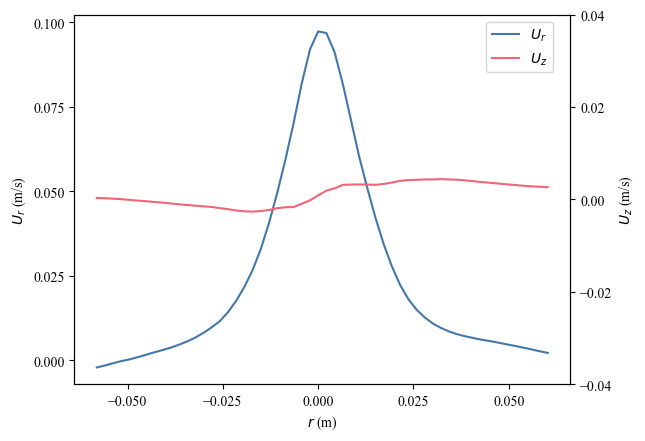

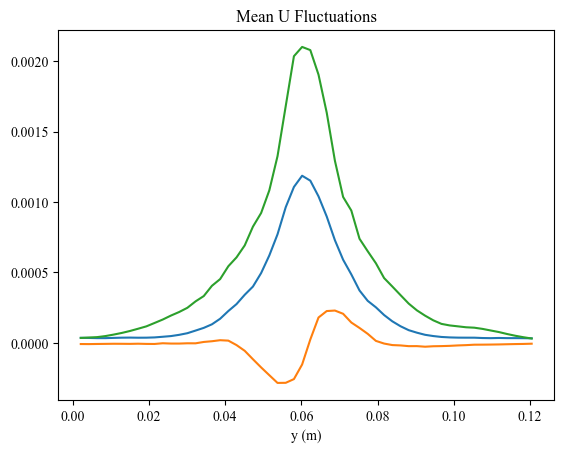

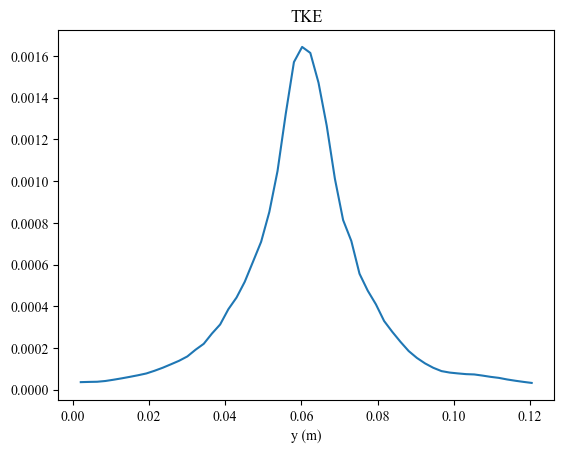

In [24]:
MAIN_PATH_Rasp = directory + '/12122023_Pylon_RaspPi_Cam/'

folder_path = MAIN_PATH_Rasp + 'data'

file_list = read_filenames(folder_path, MAIN_PATH_Rasp)

u_means, v_means, uu_means, vv_means, uv_means = [], [], [], [], []
epsilon = []

for file_name in file_list:
    data = sio.loadmat(os.path.join(folder_path, file_name))
    u_mean, v_mean, u_stack, v_stack, dtke = process_velocity(data, file_name, correlation_threshold=0.7)
    x_phy = data['xphy'].flatten()
    dxy = np.mean(np.diff(x_phy))
    u_fluctuation = u_stack - u_mean[:, np.newaxis]
    v_fluctuation = v_stack - v_mean[:, np.newaxis]
    uu = np.nanmean(u_fluctuation**2, axis=2)
    vv = np.nanmean(v_fluctuation**2, axis=2)
    uv = np.nanmean(u_fluctuation * v_fluctuation, axis=2)

    # Calculate gradients
    du1, du2 = np.gradient(u_fluctuation, dxy, axis=(0, 1))
    dv1, dv2 = np.gradient(v_fluctuation, dxy, axis=(0, 1))

    # Initialize the dissipation arrays
    shape = u_fluctuation.shape[:-1] + (u_fluctuation.shape[-1],) # Adjust shape for 3D array
    diss1 = np.zeros(shape)
    diss2 = np.zeros(shape)
    diss3 = np.zeros(shape)
    diss4 = np.zeros(shape)
    diss5 = np.zeros(shape)

    for i in range(u_fluctuation.shape[-1]):
        du2_slice = -du2[:,:,i]  # Flipping sign to match MATLAB code
        dv2_slice = -dv2[:,:,i]  # Flipping sign

        # isotropic turbulence
        diss1[:,:,i] = 15 * dv2_slice**2
        diss2[:,:,i] = 7.5 * dv1[:,:,i]**2
        # local isotropic assumption
        diss3[:,:,i] = (4*dv2_slice**2 + 4*du1[:,:,i]**2 + 3*dv1[:,:,i]**2 + 3*du2_slice**2 + 
                        4*du1[:,:,i]*dv2_slice + 6*du2_slice*dv1[:,:,i])
        # local axisymmetric assumption
        diss4[:,:,i] = (-dv2_slice**2 + 2*dv1[:,:,i]**2 + 2*du2_slice**2 + 8*du1[:,:,i]**2)
        # pseudo dissipation
        diss5[:,:,i] = (du1[:,:,i]**2 + du2_slice**2 + du1[:,:,i]**2 + 
                        dv1[:,:,i]**2 + dv2_slice**2 + dv1[:,:,i]**2 + 
                        du1[:,:,i]**2 + du2_slice**2 + du1[:,:,i]**2)
        
    if u_mean.size > 0 and v_mean.size > 0:
        u_means.append(u_mean)
        v_means.append(v_mean)
        uu_means.append(uu)
        vv_means.append(vv)
        uv_means.append(uv)
        epsilon.append(dtke)

u_means = np.array(u_means)
v_means = np.array(v_means)
uu_means = np.array(uu_means)
vv_means = np.array(vv_means)
uv_means = np.array(uv_means)
#epsilon = np.array(epsilon)

u_means_col = np.mean(u_means, axis=0)
v_means_col = np.mean(v_means, axis=0)
uu_means_col = np.mean(uu_means, axis=0)
vv_means_col = np.mean(vv_means, axis=0)
uv_means_col = np.mean(uv_means, axis=0)
diss1_col = np.nanmean(diss1, axis=2)
diss2_col = np.nanmean(diss2, axis=2)
diss3_col = np.nanmean(diss3, axis=2)
diss4_col = np.nanmean(diss4, axis=2)
diss5_col = np.nanmean(diss5, axis=2)
#epsilon_col = np.mean(epsilon, axis=0)

y_phy = data['yphy'].flatten()


tke = 0.5 * (uu_means_col + vv_means_col)

plot_aggregate_velocity(u_means_col, v_means_col, y_phy, MAIN_PATH=MAIN_PATH_Rasp)

# Plotting the fluctuations
plt.figure()
plt.title('Mean U Fluctuations')
plt.plot(y_phy, np.mean(uu_means_col, axis=0))
plt.plot(y_phy, -np.mean(uv_means_col, axis=0))
plt.plot(y_phy, np.mean(vv_means_col, axis=0))
plt.xlabel('y (m)')
plt.show()

plt.figure()
plt.title('TKE')
plt.plot(y_phy, np.mean(tke, axis=0))
plt.xlabel('y (m)')
plt.show()

In [25]:
MAIN_PATH_HighSpeed = directory + '/12122023_Phantom_High_Speed_Cam/'

folder_path = MAIN_PATH_HighSpeed + 'data'

file_list = read_filenames(folder_path, MAIN_PATH_HighSpeed)


U_means, V_means, UU_means, VV_means, UV_means = [], [], [], [], []
Epsilon = []


for file_name in file_list:
    data = sio.loadmat(os.path.join(folder_path, file_name))
    U_mean, V_mean, U_stack, V_stack, dTKE = process_velocity(data, file_name, correlation_threshold=0.7)
    print("file is ",file_name)
    X_phy = data['xphy'].flatten()
    dXY = np.mean(np.diff(X_phy))
    U_fluctuation = U_stack - U_mean[:, np.newaxis]
    V_fluctuation = V_stack - V_mean[:, np.newaxis]
    UU = np.nanmean(U_fluctuation**2, axis=2)
    VV = np.nanmean(V_fluctuation**2, axis=2)
    UV = np.nanmean(U_fluctuation * V_fluctuation, axis=2)
    if U_mean.size > 0 and V_mean.size > 0:
        U_means.append(U_mean)
        V_means.append(V_mean)
        UU_means.append(UU)
        VV_means.append(VV)
        UV_means.append(UV)
        Epsilon.append(dTKE)

    # Calculate gradients
    Du1, Du2 = np.gradient(U_fluctuation, dXY, axis=(0, 1))
    Dv1, Dv2 = np.gradient(V_fluctuation, dXY, axis=(0, 1))


    # Initialize the dissipation arrays
    Shape = U_fluctuation.shape[:-1] + (U_fluctuation.shape[-1],) # Adjust shape for 3D array
    Diss1 = np.zeros(Shape)
    Diss2 = np.zeros(Shape)
    Diss3 = np.zeros(Shape)
    Diss4 = np.zeros(Shape)
    Diss5 = np.zeros(Shape)
    
    for I in range(U_fluctuation.shape[-1]):
        Du2_slice = -Du2[:,:,I]  # Flipping sign to match MATLAB code
        Dv2_slice = -Dv2[:,:,I]  # Flipping sign

        # Isotropic turbulence
        Diss1[:,:,I] = 15 * Dv2_slice**2
        Diss2[:,:,I] = 7.5 * Dv1[:,:,I]**2
        # Local isotropic assumption
        Diss3[:,:,I] = (4*Dv2_slice**2 + 4*Du1[:,:,I]**2 + 3*Dv1[:,:,I]**2 + 3*Du2_slice**2 + 
                        4*Du1[:,:,I]*Dv2_slice + 6*Du2_slice*Dv1[:,:,I])
        # Local axisymmetric assumption
        Diss4[:,:,I] = (-Dv2_slice**2 + 2*Dv1[:,:,I]**2 + 2*Du2_slice**2 + 8*Du1[:,:,I]**2)
        # Pseudo dissipation
        Diss5[:,:,I] = (Du1[:,:,I]**2 + Du2_slice**2 + Du1[:,:,I]**2 + 
                        Dv1[:,:,I]**2 + Dv2_slice**2 + Dv1[:,:,I]**2 + 
                        Du1[:,:,I]**2 + Du2_slice**2 + Du1[:,:,I]**2)
        
# Convert lists to NumPy arrays
U_means = np.array(U_means)
V_means = np.array(V_means)
UU_means = np.array(UU_means)
VV_means = np.array(VV_means)
UV_means = np.array(UV_means)
Epsilon = np.array(Epsilon)

#print("u_means shape:", u_means.shape)
#print("v_means shape:", v_means.shape)

U_means_col = np.mean(U_means, axis=0)
V_means_col = np.mean(V_means, axis=0)
UU_means_col = np.mean(UU_means, axis=0)
VV_means_col = np.mean(VV_means, axis=0)
UV_means_col = np.mean(UV_means, axis=0)
Diss1_col = np.nanmean(Diss1, axis=2)
Diss2_col = np.nanmean(Diss2, axis=2)
Diss3_col = np.nanmean(Diss3, axis=2)
Diss4_col = np.nanmean(Diss4, axis=2)
Diss5_col = np.nanmean(Diss5, axis=2)

U_means_col = np.mean(U_means, axis=0)
V_means_col = np.mean(V_means, axis=0)
Y_phy = data['yphy'].flatten()
print("Length of Y_phy:", len(Y_phy))
print("Y_phy content:", Y_phy)


TKE = 0.5*(UU_means_col + VV_means_col)



velocity shape: (487,)
y_phy shape: (79,) x_phy shape: (36,)
(244, 36, 79)
file is  velocity_field_removing_bubble_Test1.mat
velocity shape: (487,)
y_phy shape: (79,) x_phy shape: (36,)
(244, 36, 79)
file is  velocity_field_removing_bubble_Test2.mat
Length of Y_phy: 79
Y_phy content: [0.00146625 0.0029325  0.00439875 0.005865   0.00733125 0.0087975
 0.01026375 0.01173    0.01319625 0.0146625  0.01612875 0.01759501
 0.01906126 0.02052751 0.02199376 0.02346001 0.02492626 0.02639251
 0.02785876 0.02932501 0.03079126 0.03225751 0.03372376 0.03519001
 0.03665626 0.03812251 0.03958876 0.04105501 0.04252126 0.04398751
 0.04545376 0.04692001 0.04838626 0.04985251 0.05131877 0.05278502
 0.05425127 0.05571752 0.05718377 0.05865002 0.06011627 0.06158252
 0.06304877 0.06451502 0.06598127 0.06744752 0.06891377 0.07038002
 0.07184627 0.07331252 0.07477877 0.07624502 0.07771127 0.07917752
 0.08064377 0.08211002 0.08357628 0.08504253 0.08650878 0.08797503
 0.08944128 0.09090753 0.09237378 0.09384003 0

Folder 'figures' already exists at: G:/PIV_compare/Bubble_in_chain/figures


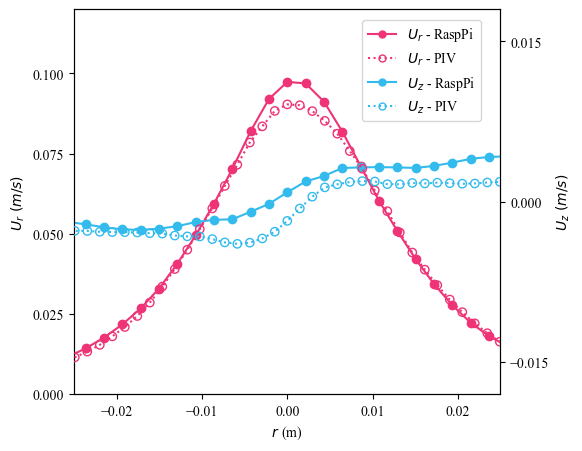

In [26]:


def plot_compare_velocity(u_means, v_means, y_phy, u_means2, v_means2, y_phy2, MAIN_PATH):
    check_folder('figures', MAIN_PATH)

    range_xlim = [-0.025, 0.025]
    range_ylimL = [0, 0.12]
    range_ylimR = [-0.018, 0.018]
    range_xlimT = [-0.025, 0.025]
    if u_means.size > 0 and v_means.size > 0:
        max_index = np.argmax(-v_means)
        y_phy_max = y_phy[max_index]
        y = y_phy - y_phy_max

        max_index2 = np.argmax(-v_means2)
        y_phy_max2 = y_phy2[max_index2]
        y2 = y_phy2 - y_phy_max2

        fig, ax1 = plt.subplots(figsize=(5.5, 5))
        
        # Plot Mean U Velocity
        color_v = '#EE3377'
        ax1.set_xlabel('$r \ $(m)', fontname='Times New Roman')
        ax1.set_ylabel('$U_r \ (m/s)$')
        line1, = ax1.plot(y, -v_means, color=color_v, label='$U_r$, RaspPi')
        ax1.scatter(y, -v_means, color=color_v)
        ax1.tick_params(axis='y')
        ax1.set_xlim(range_xlim[0], range_xlim[1])
        ax1.set_ylim(range_ylimL[0], range_ylimL[1])
        ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))
        # Create a second y-axis for Mean V Velocity
        ax2 = ax1.twinx()  
        color_u = '#33BBEE' 
        ax2.set_ylabel('$U_z \ (m/s)$') 
        line2, = ax2.plot(y, -u_means, color=color_u, label='$U_z$, RaspPi')
        ax2.scatter(y, -u_means, color=color_u)
        ax2.tick_params(axis='y')
        ax2.set_ylim(range_ylimR[0], range_ylimR[1])
        ax2.set_xlim(range_xlimT[0], range_xlimT[1])
        ax2.yaxis.set_major_locator(MaxNLocator(nbins=3))
        # Create a second x-axis for u_means2 and v_means2
        ax3 = plt.axes(ax1.get_position(), frameon=False)
        

        line3, = ax3.plot(y2, -v_means2, color=color_v,linestyle=':', label='$U_r$, PIV')
        ax3.scatter(y2, -v_means2, color=color_v, facecolors='none')

        ax3.set_xlim(range_xlim[0], range_xlim[1])
        ax3.set_ylim(range_ylimL[0], range_ylimL[1])
        ax4 = plt.axes(ax2.get_position(), frameon=False)
        ax4.set_xticks([])
        ax4.set_yticks([])
        ax4.xaxis.set_major_locator(MaxNLocator(nbins=5))
        ax4.yaxis.set_major_locator(MaxNLocator(nbins=5))
        line4, = ax4.plot(y2, -u_means2, color=color_u,linestyle=':', label='$U_z$, PIV')
        ax4.scatter(y2, -u_means2, color=color_u, facecolors='none')

        ax4.set_ylim(range_ylimR[0], range_ylimR[1])
        ax4.set_xlim(range_xlimT[0], range_xlimT[1])


        # Make ax3 ax4 invisible
        for spine in ax3.spines.values():
            spine.set_visible(False)
        ax3.xaxis.set_visible(False)
        ax3.yaxis.set_visible(False)
        for spine in ax4.spines.values():
            spine.set_visible(False)
        ax4.xaxis.set_visible(False)
        ax4.yaxis.set_visible(False)

        # Custom legend handles for scatter plots
        legend_elements = [
        Line2D([0], [0], marker='o', color=color_v, label='$U_r$ - RaspPi ', markersize=5),
        Line2D([0], [0], marker='o', color=color_v, label='$U_r$ - PIV ',markerfacecolor='none', markersize=5, linestyle=':'),
        Line2D([0], [0], marker='o', color=color_u, label='$U_z$ - RaspPi ', markersize=5),
        Line2D([0], [0], marker='o', color=color_u, label='$U_z$ - PIV ',markerfacecolor='none', markersize=5, linestyle=':')
        ]

        # Combined legend
        #lines = [line1, line2, line3, line4]
        #labels = [l.get_label() for l in lines]
        #ax1.legend(lines, labels, bbox_to_anchor=(0.66, 0.99), loc='upper left')
        ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.66, 0.99))
        # Save and show the figure
        plt.savefig(MAIN_PATH + 'figures/Chain_mean_flow.png', bbox_inches='tight',dpi=300)
        plt.show()
        plt.close()
    else:
        print("No valid data to plot.")

plot_compare_velocity(u_means_col, v_means_col, y_phy, U_means_col, V_means_col, Y_phy, MAIN_PATH=directory+'/')


Folder 'figures' already exists at: G:/PIV_compare/Bubble_in_chain/figures


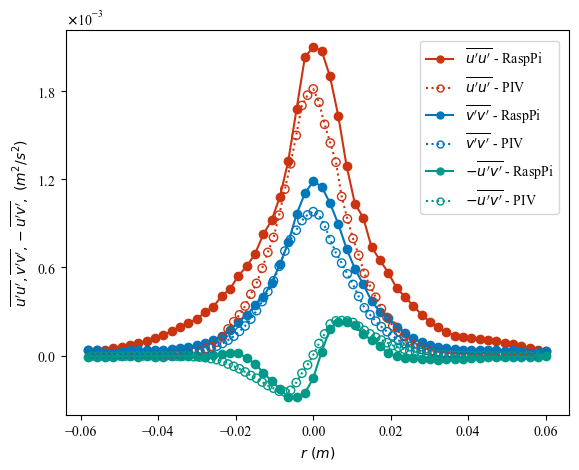

In [30]:
def plot_compare_Sheer_velocity(u_means, v_means, uv_means, y_phy, u_means2, v_means2, uv_means2, y_phy2, MAIN_PATH):
    check_folder('figures', MAIN_PATH)

    if u_means.size > 0 and v_means.size > 0:
        max_index = np.argmax(-v_means)
        if max_index >= y_phy.size:
            print("Error: max_index is out of bounds for y_phy.")
            return

        y_phy_max = y_phy[max_index]
        y = y_phy - y_phy_max

        max_index2 = np.argmax(-v_means2)
        y_phy_max2 = y_phy2[max_index2]
        y2 = y_phy2 - y_phy_max2

        fig, ax1 = plt.subplots(figsize=(6.5, 5))
        colors = {'uu': '#CC3311', 'vv': '#0077BB', 'uv': '#009988'}

        # Plotting
        for data, color, label, linestyle in [(v_means, 'uu', '$U_r$, RaspPi', '-'), 
                                              (u_means, 'vv', '$\\overline{u\'u\'}$, RaspPi', '-'),
                                              (uv_means, 'uv', '$\\overline{u\'v\'}$, RaspPi', '-'),
                                              (v_means2, 'uu', '$U_r$, PIV', ':'),
                                              (u_means2, 'vv', '$U_z$, PIV', ':'),
                                              (uv_means2, 'uv', '$U_z$, PIV', ':')]:
            ax1.plot(y if 'PIV' not in label else y2, -data, color=colors[color], linestyle=linestyle, label=label)
            ax1.scatter(y if 'PIV' not in label else y2, -data, color=colors[color], facecolors='none' if 'PIV' in label else colors[color])

        ax1.set_xlabel('$r \ (m)$', fontname='Times New Roman')
        ax1.set_ylabel('$\\overline{u\'u\'}, \\overline{v\'v\'}, -\\overline{u\'v\'},\ (m^2/s^2)$')
        ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))

        ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        # Custom legend
        legend_elements = [Line2D([0], [0], marker='o', color=colors[key], label=value, markersize=5, markerfacecolor='none' if 'PIV' in value else colors[key], linestyle=':' if 'PIV' in value else '-') for key, value in [('uu', '$\\overline{u\'u\'}$ - RaspPi'), ('uu', '$\\overline{u\'u\'}$ - PIV'), ('vv', '$\\overline{v\'v\'}$ - RaspPi'), ('vv', '$\\overline{v\'v\'}$ - PIV'), ('uv', '$-\\overline{u\'v\'}$ - RaspPi'), ('uv', '$-\\overline{u\'v\'}$ - PIV')]]
        ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.69, 0.99))

        # Save and show the figure
        plt.savefig(os.path.join(MAIN_PATH, 'figures/Chain_SheerVel.png'), bbox_inches='tight', dpi=300)
        plt.show()
        plt.close()
        return y, y2
    else:
        print("No valid data to plot.")

r, R = plot_compare_Sheer_velocity(-np.mean(uu_means_col,axis=0), -np.mean(vv_means_col,axis=0),np.mean(uv_means_col,axis=0),  y_phy, -np.mean(UU_means_col,axis=0), -np.mean(VV_means_col,axis=0), np.mean(UV_means_col,axis=0), Y_phy, MAIN_PATH=directory+'/')


Folder 'figures' already exists at: G:/PIV_compare/Bubble_in_chain/figures


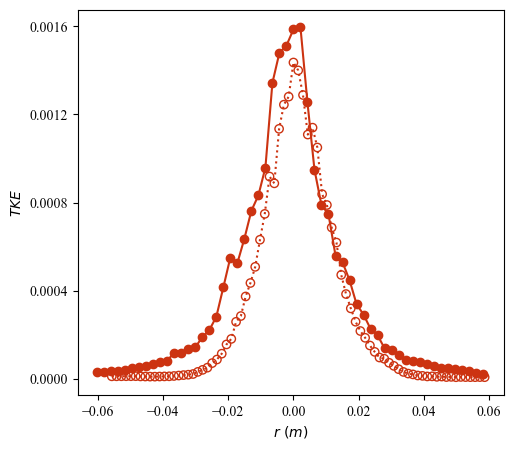

In [28]:
def plot_compare_tke_velocity(u_means, y_phy, u_means2, y_phy2, MAIN_PATH):
    check_folder('figures', MAIN_PATH)

    if u_means.size > 0 and v_means.size > 0:
        max_index = np.argmax(-v_means)
        if max_index >= y_phy.size:
            print("Error: max_index is out of bounds for y_phy.")
            return

        y_phy_max = y_phy[max_index]
        y = y_phy - y_phy_max

        max_index2 = np.argmax(-u_means2)
        y_phy_max2 = y_phy2[max_index2]
        y2 = y_phy2 - y_phy_max2

        fig, ax1 = plt.subplots(figsize=(5.5, 5))
        colors = {'uu': '#CC3311', 'vv': '#0077BB', 'uv': '#009988'}

        # Plotting
        for data, color, label, linestyle in [(u_means, 'uu', '$TKE$, RaspPi', '-'), 
                                              (u_means2, 'uu', '$TKE$, PIV', ':')]:
            ax1.plot(y if 'PIV' not in label else y2, -data, color=colors[color], linestyle=linestyle, label=label)
            ax1.scatter(y if 'PIV' not in label else y2, -data, color=colors[color], facecolors='none' if 'PIV' in label else colors[color])

        ax1.set_xlabel('$r \ (m)$', fontname='Times New Roman')
        ax1.set_ylabel('$TKE$')
        ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))

        # Custom legend
        #legend_elements = [Line2D([0], [0], marker='o', color=colors[key], label=value, markersize=5, markerfacecolor='none' if 'PIV' in value else colors[key], linestyle=':' if 'PIV' in value else '-') for key, value in [('uu', '$\\overline{u\'u\'}$ - RaspPi'), ('uu', '$\\overline{u\'u\'}$ - PIV'), ('vv', '$\\overline{v\'v\'}$ - RaspPi'), ('vv', '$\\overline{v\'v\'}$ - PIV'), ('uv', '$\\overline{u\'v\'}$ - RaspPi'), ('uv', '$\\overline{u\'v\'}$ - PIV')]]
        #ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.66, 0.99))

        # Save and show the figure
        plt.savefig(os.path.join(MAIN_PATH, 'figures/Chain_TKE.png'), bbox_inches='tight', dpi=300)
        plt.show()
        plt.close()
    else:
        print("No valid data to plot.")

plot_compare_tke_velocity(-tke[10],  y_phy, -TKE[10], Y_phy, MAIN_PATH=directory+'/')


In [1]:
# Dissipation rate 

def plot_compare_epsilon_velocity(u_means, y_phy, u_means2, y_phy2, MAIN_PATH):
    check_folder('figures', MAIN_PATH)  # Assuming check_folder is defined

    fig, ax1 = plt.subplots(figsize=(6.5, 5))
    lw = 2  # line width, adjust as needed

    # Plotting
    ax1.plot(y_phy, -u_means, 'ko-', color="#0077BB", linewidth=lw, label='RpiPIV')
    ax1.plot(y_phy2, -u_means2, 'ko-', color="#33BBEE", label='PIV')

    ax1.set_xlabel('$r$ (m)', fontsize=15, fontname='Times New Roman')
    ax1.set_ylabel('$\epsilon$ (m$^2$/s$^3$)', fontsize=15, fontname='Times New Roman')
    ax1.set_yscale('log')
    ax1.legend(fontsize=15)
    ax1.tick_params(axis='both', which='major', labelsize=15)
    #ax1.set_xlim([0, 0.08])

    plt.tight_layout()
    plt.savefig(os.path.join(MAIN_PATH, 'figures/Chain_Dissipation.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()
Ztest1, Ztest2 = KINEMATIC_VISCOSITY*-diss4_col[1,:], KINEMATIC_VISCOSITY*-Diss4_col[1,:]

plot_compare_epsilon_velocity(KINEMATIC_VISCOSITY*np.nanmean(-diss4_col,axis=0), y_phy, KINEMATIC_VISCOSITY*np.nanmean(-Diss4_col,axis=0), Y_phy, MAIN_PATH=directory+'/')


NameError: name 'KINEMATIC_VISCOSITY' is not defined